In [2]:
import fluxback as fb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [3]:
data = pd.read_csv("iris.csv")
data.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [4]:
X = data.iloc[:, :4].to_numpy()
y = data.iloc[:, 4].to_numpy()

X.shape, y.shape

((150, 4), (150,))

In [5]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(y[:, None])

ohe.categories_

[array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)]

In [6]:
ohe.transform([['Setosa'], ['Versicolor'], ['Virginica']])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [7]:
y_enc = ohe.transform(y[:, None])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [9]:
fc1_weights = fb.Tensor.randn((4, 32), requires_grad=True)
fc1_weights.autodiff_role = "Weight 1"
fc1_bias = fb.Tensor.randn((32,), requires_grad=True)
fc1_bias.autodiff_role = "Bias 1"
fc2_weights = fb.Tensor.randn((32,3), requires_grad=True)
fc2_weights.autodiff_role = "Weight 2"
fc2_bias = fb.Tensor.randn((3,), requires_grad=True)
fc2_bias.autodiff_role = "Bias 2"

In [13]:
from collections import defaultdict
from sklearn.utils import gen_batches
history = defaultdict(list)
epochs = 5
lr = 1
relu = fb.activation.LeakyReLU()
softmax = fb.activation.SoftMax()

y_train_ohe = ohe.transform(y_train[:,None])

for i in range(epochs):
	for j, batch in enumerate(gen_batches(X_train.shape[0], 5)):
		X_batch = X_train[batch]
		y_batch = y_train_ohe[batch]
		x1 = fb.Tensor(X_train) @ fc1_weights + fc1_bias
		y1 = relu(x1)
		x2 = x1 @ fc2_weights + fc2_bias
		y2 = softmax(x2)

		loss = - (y2.log() * y_train_ohe).sum()
		

		history['epoch'].append(i*20 + j)
		history['loss'].append(loss.values)
		act_label = np.argmax(y2.values, axis=1)
		pred_label = np.argmax(y_train_ohe, axis=1)
		history['accuracy'].append((act_label == pred_label).mean())

		loss.zero()
		loss.back()
		fc1_weights -= (lr * fc1_weights.grad)
		fc1_bias -= (lr * fc1_bias.grad)
		fc2_weights -= (lr * fc2_weights.grad)
		fc2_bias -= (lr * fc2_bias.grad)

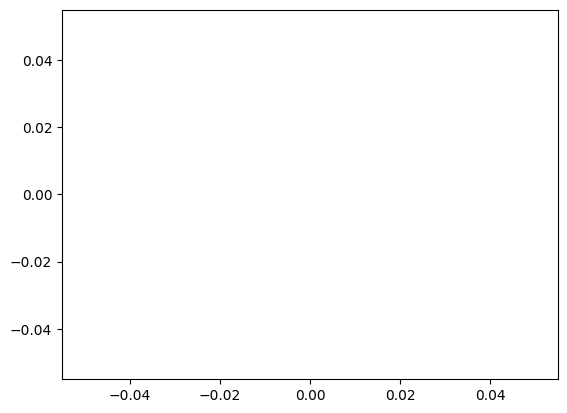

In [14]:
import matplotlib.pyplot as plt

plt.plot(history['epoch'], history['loss'])

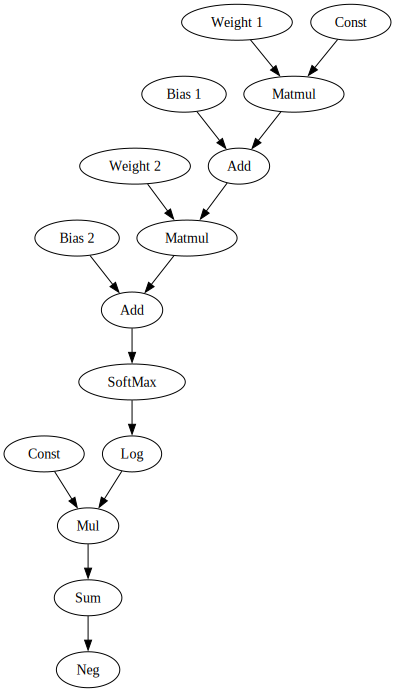

In [12]:
loss.graphviz()